**Run notebook online with Binder:**[![Binder](http://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/LabForComputationalVision/plenoptic/master?filepath=examples/Demo_Eigendistortion.ipynb)

# Eigendistortions of hierarchical representations
Author: Lyndon Duong, Jan 2021

In this demo, we will be reproducing eigendistortions first presented in [Berardino et al 2017](https://arxiv.org/abs/1710.02266).
We'll be using a Front End model of the human visual system (called "On-Off" in the paper), as well as an early layer
of VGG16.
The Front End model is a simple convolutional neural network with a normalization nonlinearity, loosely
based on biological retinal/geniculate circuitry.

![Front-end model](./assets/eigendistortions/front_end_model.png)

This signal-flow diagram shows an input being decomposed into two channels, with each being luminance and contrast
normalized, and ending with a ReLu.

## What do eigendistortions tell us?
Our perception is influenced by our internal representation (neural responses) of the external world.
Eigendistortions are rank-ordered directions in image space, along which a model's responses are more sensitive.
``Plenoptic``'s ``Eigendistortion`` object provides an easy way to synthesize eigendistortions for any PyTorch model.

In [1]:
from plenoptic.synthesize import Eigendistortion
from plenoptic.simulate.models import OnOff
from torchvision.models import vgg16
import torch
from torch import nn
import plenoptic as po

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

/home/billbrod/miniconda3/envs/plenoptic/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device:  cpu


In [2]:
max_iter_frontend = 10
max_iter_vgg = 10

## Input preprocessing
Let's load the parrot image used in the paper, display it, and cast it as a ``float32`` tensor.

Torch image shape: torch.Size([1, 1, 254, 254])


/home/billbrod/Documents/plenoptic/plenoptic/tools/data.py:126: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  images = torch.tensor(images, dtype=torch.float32)


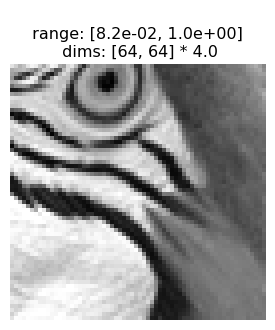

In [3]:
image = po.load_images('../data/Parrot.png', as_gray=False)
zoom = 1

def crop(img):
    """Returns 2D numpy as image as 4D tensor Shape((b, c, h, w))"""
    img_tensor = img.clone()
    return img_tensor[...,:254,:254]  # crop to same size

image_tensor = crop(image).to(device)
print("Torch image shape:", image_tensor.shape)

# reduce size of image if we're on CPU, otherwise this will take too long
if device.type == 'cpu':
    image_tensor = image_tensor[...,100:164,100:164]
    # want to zoom so this is displayed at same size
    zoom = 256 / 64
    
po.imshow(image_tensor, zoom=zoom);


Since the Front-end OnOff model only has two channel outputs, we can easily visualize the feature maps.
We'll apply a circular mask to this model's inputs to avoid edge artifacts in the synthesis method.

/home/billbrod/Documents/plenoptic/plenoptic/simulate/models/frontend.py:388: UserWarning: pretrained is True but cache_filt is False. Set cache_filt to True for efficiency unless you are fine-tuning.
  warn("pretrained is True but cache_filt is False. Set cache_filt to "
/home/billbrod/miniconda3/envs/plenoptic/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


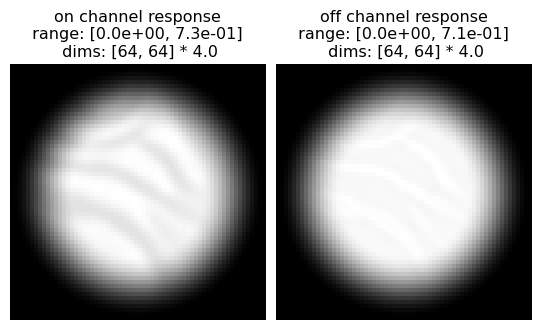

In [4]:
mdl_f = OnOff(kernel_size=(31, 31), pretrained=True, apply_mask=True)
po.tools.remove_grad(mdl_f)
mdl_f = mdl_f.to(device)

response_f = mdl_f(image_tensor)
po.imshow(response_f, title=['on channel response', 'off channel response'], zoom=zoom);

## Synthesizing eigendistortions

### Front-end model: eigendistortion synthesis
Now that we have our Front End model set up, we can synthesize eigendistortions!
This is done easily just by calling ``.synthesis()`` after instantiating the ``Eigendistortion`` object.
We'll synthesize the top and bottom ``k``, representing the most- and least-noticeable eigendistortions for this model.

The paper synthesizes the top and bottom ``k=1`` eigendistortions, but we'll set ``k>1`` so the algorithm
converges/stabilizes faster.
We highly recommended running the following block on GPU, otherwise we suggest cropping the image to a smaller
size.

In [5]:
# synthesize the top and bottom k distortions
eigendist_f = Eigendistortion(image=image_tensor, model=mdl_f)
eigendist_f.synthesize(k=3, method='power', max_iter=max_iter_frontend)

/home/billbrod/Documents/plenoptic/plenoptic/tools/validate.py:174: UserWarning: model is in training mode, you probably want to call eval() to switch to evaluation mode
  warnings.warn(



Initializing Eigendistortion -- Input dim: 4096 | Output dim: 8192


Bottom k=3 eigendists: 100%|███████████████████████████████| 10/10 [00:01<00:00,  6.99it/s, delta_eigenval=2.94E-04]


### Front-end model: eigendistortion display

Once synthesized, we can plot the distortion on the image using ``Eigendistortion``'s built-in display method.
Feel free to adjust the constants ``alpha_max`` and ``alpha_min`` that scale the amount of each distortion on the image.

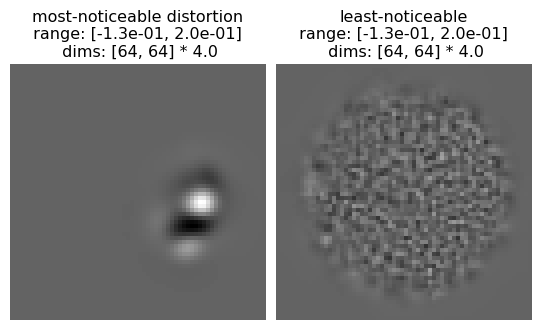

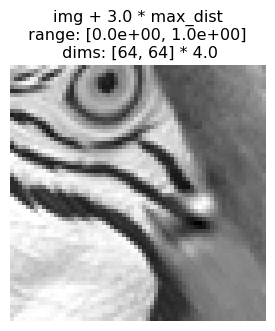

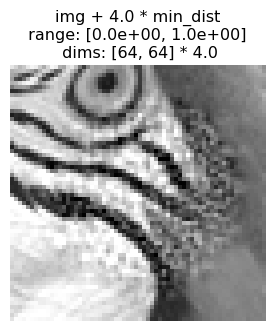

In [6]:
po.imshow(eigendist_f.eigendistortions[[0,-1]].mean(1, keepdim=True), vrange='auto1',
          title=["most-noticeable distortion", "least-noticeable"], zoom=zoom)

alpha_max, alpha_min = 3., 4.
f_max = po.synth.eigendistortion.display_eigendistortion(eigendist_f, eigenindex=0, alpha=alpha_max, 
                                                         title=f'img + {alpha_max} * max_dist', zoom=zoom)
f_min = po.synth.eigendistortion.display_eigendistortion(eigendist_f, eigenindex=-1, alpha=alpha_min, 
                                                         title=f'img + {alpha_min} * min_dist', zoom=zoom)

### VGG16: eigendistortion synthesis
Following the lead of Berardino et al. (2017), let's compare the Front End model's eigendistortion to those of an
early layer of VGG16!
VGG16 takes as input color images, so we'll need to repeat the grayscale parrot along the RGB color dimension.

In [7]:
# Create a class that takes the nth layer output of a given model
class NthLayerVGG16(nn.Module):
    """Wrapper to get the response of an intermediate layer of VGG16"""
    def __init__(self, layer: int = None, device=torch.device('cpu')):
        """
        Parameters
        ----------
        layer: int
            Which model response layer to output
        """
        super().__init__()
        model = vgg16(pretrained=True, progress=True).to(device)
        features = list(model.features)
        self.features = nn.ModuleList(features).eval()

        if layer is None:
            layer = len(self.features)
        self.layer = layer

    def forward(self, x):
        for ii, mdl in enumerate(self.features):
            x = mdl(x)
            if ii == self.layer:
                return x

VGG16 was trained on pre-processed ImageNet images with approximately zero mean and unit stdev, so we can preprocess
our Parrot image the same way.

In [12]:
# VGG16
def normalize(img_tensor):
    """standardize the image for vgg16"""
    return (img_tensor-img_tensor.mean())/ img_tensor.std()
image_tensor = normalize(crop(image)).to(device)

# reduce size of image if we're on CPU, otherwise this will take too long
if device.type == 'cpu':
    image_tensor = image_tensor[...,100:164,100:164]
    # want to zoom so this is displayed at same size
    zoom = 256 / 64

image_tensor3 = torch.cat([image_tensor]*3, dim=1).to(device)

# "layer 3" according to Berardino et al (2017)
mdl_v = NthLayerVGG16(layer=11, device=device)
po.tools.remove_grad(mdl_v)

eigendist_v = Eigendistortion(image=image_tensor3, model=mdl_v)
eigendist_v.synthesize(k=2, method='power', max_iter=max_iter_vgg)


Initializing Eigendistortion -- Input dim: 12288 | Output dim: 65536


Bottom k=2 eigendists: 100%|███████████████████████████████| 10/10 [00:00<00:00, 19.45it/s, delta_eigenval=3.94E+02]


### VGG16: eigendistortion display
We can now display the most- and least-noticeable eigendistortions as before, then compare their quality to those of
the Front-end model.

Since the distortions here were synthesized using a pre-processed (normalized) imagea, we can easily pass a function to
unprocess the image.
Since the previous eigendistortions were grayscale, we'll just take the mean across RGB channels for
VGG16-synthesized eigendistortions and display them as grayscale too.

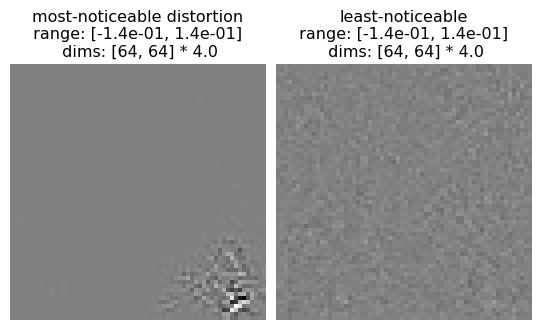

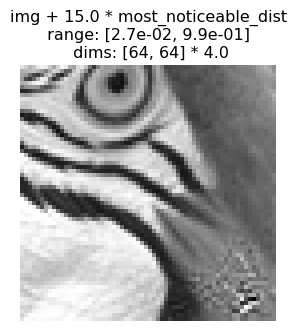

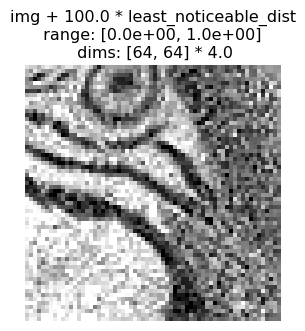

In [13]:
po.imshow(eigendist_v.eigendistortions[[0,-1]].mean(1, keepdim=True), vrange='auto1',
          title=["most-noticeable distortion", "least-noticeable"], zoom=zoom)

# create an image processing function to unnormalize the image and avg the channels to grayscale
unnormalize = lambda x: (x*image.std() + image.mean()).mean(1, keepdims=True)
alpha_max, alpha_min = 15., 100.

v_max = po.synth.eigendistortion.display_eigendistortion(eigendist_v, eigenindex=0, alpha=alpha_max, 
                                                         process_image=unnormalize,
                                                         title=f'img + {alpha_max} * most_noticeable_dist', 
                                                         zoom=zoom)
v_min = po.synth.eigendistortion.display_eigendistortion(eigendist_v, eigenindex=-1, alpha=alpha_min, 
                                                         process_image=unnormalize,
                                                         title=f'img + {alpha_min} * least_noticeable_dist', 
                                                         zoom=zoom)

## Final thoughts

To rigorously test which of these model's representations are more human-like, we'll have to conduct a perceptual
experiment.
For now, we'll just leave it to you to eyeball and decide which distortions are more or less noticeable!